## ViT

In [1]:
### FashionMNIST 다운로드
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets

- from itertools import chain
  - 여러 iterable(리스트, 튜플 등)을 연결해서 하나의 iterator로
  - 단순 + 보다 메모리 효율이 좋음
- from collections import defaultdict
  - 딕셔너리에 키가 없어도 기본값을 자동으로 생성

In [2]:
### from collections import defaultdict

# 기본값이 list인 딕셔너리
d = defaultdict(list)

d['a'].append(1)
d['a'].append(2)
d['b'].append(3)

print(d)  ## defaultdict(<class 'list'>, {'a': [1, 2], 'b': [3]})

defaultdict(<class 'list'>, {'a': [1, 2], 'b': [3]})


In [3]:
def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(classes)
print(class_to_idx)

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"Training Data Size : {len(subset_train_dataset)}")
print(f"Testing Data Size : {len(subset_test_dataset)}")
print(train_dataset[0])

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Training Data Size : 10000
Testing Data Size : 1000
(<PIL.Image.Image image mode=L size=28x28 at 0x7899A129A090>, 9)


In [4]:
### 이미지 전처리

import torch
from torchvision import transforms
from transformers import AutoImageProcessor


image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f"size : {image_processor.size}")
print(f"mean : {image_processor.image_mean}")
print(f"std : {image_processor.image_std}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


size : {'height': 224, 'width': 224}
mean : [0.5, 0.5, 0.5]
std : [0.5, 0.5, 0.5]


- transforms.Lambda(lambda x: torch.cat([x, x, x], 0)
  - 흑백 1채널 이미지 -> 3번 복사해 3채널 이미지로 변환
  - 채널 정보를 늘리는 것일 뿐, 진짜 RGB 변환은 아님
  - 입력이 3채널이어야만 작동하는 모델에 에러 없이 넣어주기 위함

- ViT 모델의 입력: {"pixel_values": pixel_values, "Labels": labels}의 형태
  - Tensor 형식의 데이터가 아닌, 딕셔너리 형식의 데이터를 입력으로 받음
  - 데이터로더에 집합 함수(collate_fn)를 적용해 여러 개의 (image, label) 샘플을 하나의 배치로 묶음
  - 이 함수로 ViT 모델 구조에 맞는 딕셔너리 형태로 변환해 데이터로더에 적용

In [5]:
from torch.utils.data import DataLoader

def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    # transform: 앞서 정의한 전처리 함수
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

batch = next(iter(train_dataloader))
for key, value in batch.items():
    print(f"{key} : {value.shape}")

pixel_values : torch.Size([32, 3, 224, 224])
labels : torch.Size([32])


In [6]:
### 사전 학습된 ViT 모델

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
    num_labels=len(classes),
    id2label={idx: label for label, idx in class_to_idx.items()},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)
print(model.classifier)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


- 허깅페이스 라이브러리의 ViT 이미지 분류 모델 클래스(ViTForImageClassification)를 통해 사전 학습된 모델 불러오기
- 매개 변수를 통해 ViT 이미지 분류 모델 클래스 파인튜닝: 현재 데이터셋에 적합한 구조로
  - num_lables: 레이블 개수
  - id2label: ID/레이블
  - label2id: 레이블/ID
- 출력 결과에서 분류기(classifier)의 출력 데이터 차원 크기를 10개로 반환함을 확인할 수 O
- class_to_idx: torchvision의 ImageFolder에서 자동 생성됨
  ```
  class_to_idx = {
    "cat": 0,
    "dog": 1,
    "elephant": 2
    }
  ```

In [7]:
### 패치 임베딩 확인
print(model.vit.embeddings)

batch = next(iter(train_dataloader))
print("image shape :", batch["pixel_values"].shape)
print("patch embeddings shape :",
    model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape
)
print("[CLS] + patch embeddings shape :",
    model.vit.embeddings(batch["pixel_values"]).shape
)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
image shape : torch.Size([32, 3, 224, 224])
patch embeddings shape : torch.Size([32, 196, 768])
[CLS] + patch embeddings shape : torch.Size([32, 197, 768])


- 패치 임베딩 함수: 16*16 커널, 16 스트라이드의 Conv2d 연산 수행
- 패치 임베딩 생성 후 임베딩 함수 수행: modeil.vit.embeddings
- 224×224 이미지를 16×16 패치로 나누면 196개가 생김
- 여기에 [CLS]를 붙여 총 197개의 임베딩(각각 768차원) -> ViT 모델의 입력이 됨

In [8]:
### 하이퍼파라미터 설정

from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",  # evaluation_strategy에서 변경됨
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

![image.png](attachment:501a2c6e-05bb-456c-9b16-73884b6070df.png)

![image.png](attachment:54c02e02-bf11-4af7-9a06-c07eef9b3e0a.png)

In [10]:
# !pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [11]:
### 성능 평가 지표: Macro Average F1-Score

import evaluate
import numpy as np

def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

- eval_pred: 모델이 예측한 결괏값을 전달받음
  - 모든 클래스에 대한 예측값 포함됨
- 가장 확률이 높은 값을 선택해 predictions 변수에 저장

-------
## 사실상 여기서부터만 실행해도 무관

In [12]:
### ViT 모델 학습

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


# 얘만 새로 정의. 나머지는 이미 정의했던 것
def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

In [13]:
train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [15]:
args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none" # 코랩에서 돌릴 경우 활성화
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

<ipython-input-15-6b313e7b1ad8>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.700100,0.632578,0.886868
2,0.476700,0.473856,0.911090
3,0.416700,0.426882,0.920968


TrainOutput(global_step=1875, training_loss=0.6970961934407552, metrics={'train_runtime': 1066.4654, 'train_samples_per_second': 28.13, 'train_steps_per_second': 1.758, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6970961934407552, 'epoch': 3.0})

- 트랜스포머스 라이브러리의 훈련자 클래스(Trainer)를 통해 ViT 모델 학습
  - 훈련자 클래스는 모델을 함수(model_init)의 형태로 생성해 전달
  - 훈련자 클래스는 데이터로더가 내부적으로 수행됨
    => 데이터세트, 집합 함수 등을 함께 전달
- 학습이 완료되면 ViT-FashionMNIST 폴더에 체크포인트마다 학습 결과, 성능 지표, 하이퍼파라미터 등이 저장됨

PredictionOutput(predictions=array([[ 3.0722842 , -0.63841504, -0.29865408, ..., -0.579745  ,
        -0.32789698, -0.6074605 ],
       [ 2.072034  , -0.6885157 , -0.24669428, ..., -0.8297396 ,
        -0.8257852 , -0.95410043],
       [ 2.995471  , -0.6021513 , -0.16138181, ..., -0.5226669 ,
        -0.36727345, -0.6038809 ],
       ...,
       [-0.5784347 , -0.60892874, -0.53849375, ...,  0.60372555,
         0.37911075,  2.9814434 ],
       [-0.5550974 , -0.38791537, -0.3086287 , ...,  0.13592863,
        -0.30320463,  3.3962846 ],
       [-0.5318418 , -0.32698768, -0.2928442 , ..., -0.2789853 ,
        -0.15928861,  3.416874  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

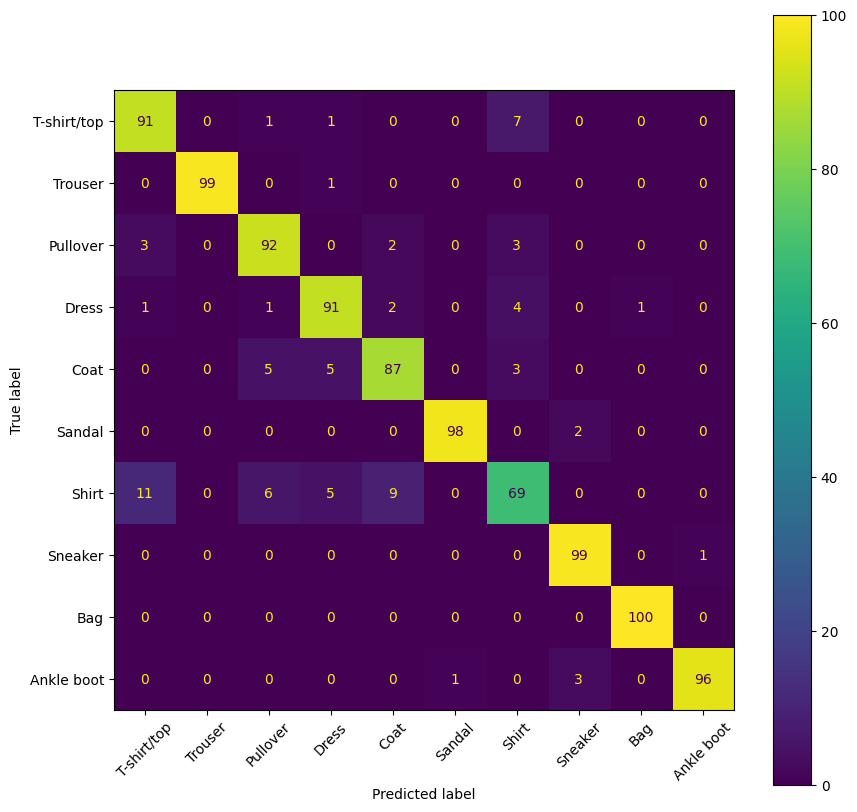

In [16]:
### ViT 모델 성능 평가

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()